In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm
import datetime

## Pre

In [ ]:
# refresh data
from WindPy import w
w.start()

begindate='2010-01-01'
enddate='2021-08-31'
error_code, etf50 = w.wsd("510050.OF", "pre_close, close", begindate, enddate, "",usedf=True)
etf50.columns = etf50.columns.str.lower()

etf50 = etf50.reset_index()
etf50.columns = ['date','pre_close','close']
etf50.to_csv('50etf.csv',index=False)

In [46]:
etf50 = pd.read_csv('50etf.csv',parse_dates=['date'])

### daily

In [ ]:
# datelist=w.tdays(begindate, enddate, "").Data[0]
# continuously compounded return = dlnS = ln(close/previous close)
etf50['log_ret'] = np.log(etf50.close/etf50.pre_close)
# etf50['log_ret1'] = np.log(etf50.close/etf50.close.shift(1))
etf50['ret'] = etf50.close/etf50.pre_close - 1
etf50['log_close'] = np.log(etf50['close'])
etf50.head()

### monthly

In [47]:
etf50 = etf50.drop(['pre_close'],axis=1)
etf50 = etf50.groupby([etf50['date'].dt.year,etf50['date'].dt.month],as_index=False).nth(-1)
etf50 = etf50.reset_index(drop=True)
etf50['log_close'] = np.log(etf50['close'])
etf50['log_ret'] = etf50.log_close.diff()
etf50['ret'] = etf50['close'].diff()/etf50['close'].shift()

## 连续复利收益率

\begin{equation}
    d \ln S \sim N\left( (\mu-\frac{1}{2}\sigma^2)\frac{1}{252}, \sigma^2 \frac{1}{252} \right)
\end{equation}

mean = 0.0024124148679884245, sigma = 0.06543157374708318
mu = 0.610069192154593, sigma = 1.0386940321581886


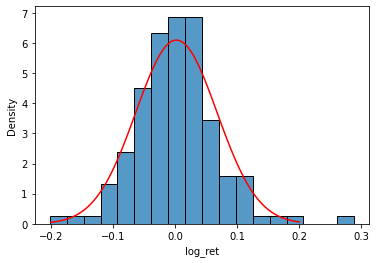

In [75]:
sns.histplot(etf50['log_ret'],stat='density')
logr_mu = etf50.log_ret.mean()
logr_sigma = etf50.log_ret.std()
x = np.linspace(-0.2,0.2, 100)
plt.plot(x, norm.pdf(x, logr_mu, logr_sigma), color='red')

sigma = np.sqrt(252*logr_sigma**2)
mu= 252*logr_mu + 0.5*logr_sigma**2
print("mean = {}, sigma = {}".format(logr_mu,logr_sigma))
print("mu = {}, sigma = {}".format(mu,sigma))

## 百分比收益率

mean = 0.004572765744309274, sigma = 0.06706617188553038
mu = 0.6079285467330829, sigma = 1.064642473165351


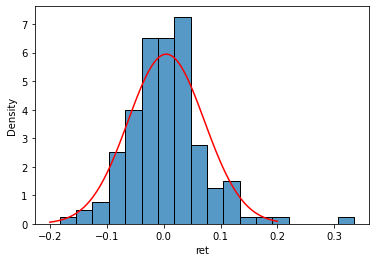

In [76]:
# 依然是正态分布？？？
sns.histplot(etf50['ret'],stat='density')
ret_mu = etf50.ret.mean()
ret_sigma = etf50.ret.std()
x = np.linspace(-0.2,0.2, 100)
plt.plot(x, norm.pdf(x, ret_mu, ret_sigma), color='red')

sigma = np.sqrt(252*ret_sigma**2)
mu= 252*logr_mu
print("mean = {}, sigma = {}".format(ret_mu,ret_sigma))
print("mu = {}, sigma = {}".format(mu,sigma))

## ln S_t

\begin{equation*}
    \ln S_T  \sim N \left(\ln S_t + (\mu-\frac{\sigma^2}{2})(T-t), \sigma^2(T-t)\right)
\end{equation*}

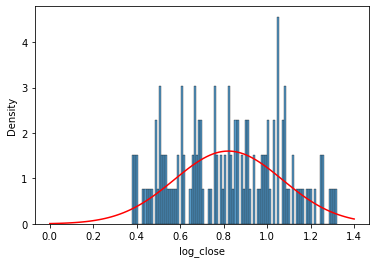

In [67]:
sns.histplot(etf50['log_close'],stat='density',bins=100)

logc_mu = etf50.log_close.mean()
logc_sigma = etf50.log_close.std()
x = np.linspace(0,1.4, 100)
plt.plot(x, norm.pdf(x, logc_mu, logc_sigma), color='red')

## S_t

\begin{equation*}
    S_T  \sim logN \left(\ln S_t + (\mu-\frac{\sigma^2}{2})(T-t), \sigma^2(T-t)\right)
\end{equation*}

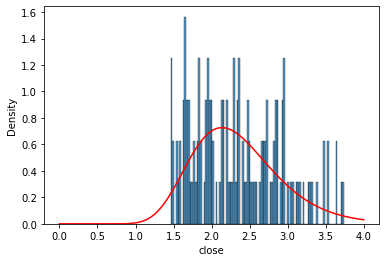

In [68]:
sns.histplot(etf50['close'],stat='density',bins=100)

x = np.linspace(0,4, 100)
plt.plot(x, lognorm.pdf(x, logc_sigma, 0, np.exp(logc_mu)), color='red')

<AxesSubplot:xlabel='ret', ylabel='Density'>

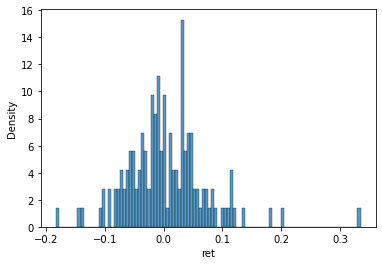

In [69]:
sns.histplot(etf50['ret'],stat='density',bins=100)

## Plot

In [ ]:
etf50['volatility_yearly'] = etf50['log_ret'].rolling(window=252).std()*np.sqrt(252)
etf50['volatility_monthly'] = etf50['log_ret'].rolling(window=21).std()*np.sqrt(252)
etf50[['close','volatility_monthly','volatility_yearly']].plot(subplots=True, color='blue',figsize=(8, 6))

## Geometric brownian motion

In [ ]:
# 每一步，即每个\Delta t 都应该抽取一个随机数，都是独立的exp部分抽取随机数，并且累乘

\begin{align}
    \ln S(t +\Delta t) - \ln S(t) = \left( r - \frac{\sigma^2}{2} \right) + \sigma \varepsilon \sqrt{\Delta t} \\
    S(t + \Delta t) = S(t)\exp\left[(r - \frac{\sigma^2}{2})\Delta t + \sigma \varepsilon \sqrt{\Delta t} \right]
\end{align}

In [ ]:
# monte carlo simulation
# https://en.wikipedia.org/wiki/Geometric_Brownian_motion

mu = 0.05
n = 5000
dt = 0.01
x0 = 100
np.random.seed(1)

sigma = np.arange(0.1, 0.35, 0.05) # different sigma

# calculate exponential part
x = np.exp((mu - sigma ** 2 / 2) * dt 
           + sigma * np.random.normal(0, 1, size=(n, len(sigma))) * np.sqrt(dt))
x = np.vstack([np.ones(len(sigma)), x])
# !!!scale by initial value, and cumulative product along with axis 0 (row)!!!
x = x0 * x.cumprod(axis=0)

plt.plot(x)
plt.legend(np.round(sigma, 2))
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(
    'Realizations of Geometric Brownian Motion with different variances\n $\mu={}$'.format(mu)
)
plt.show()

## BSM & Black

In [ ]:
# bls model
def bls_price(S,K,r,T,sigma,cp_flag):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if cp_flag == 'C':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif cp_flag == 'P':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
def bls_vega(S,K,r,T,sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    vega = S * norm.pdf(d1, 0.0, 1.0) * np.sqrt(T)
    return vega

def bls_impv(S,K,r,T,value,cp_flag):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(MAX_ITERATIONS):
        # every iter calculate a new pair of price and vega
        price = bls_price(S,K,r,T,sigma,cp_flag)
        vega = bls_vega(S,K,r,T,sigma)
        diff = price - value
        if (abs(diff) < PRECISION):
            return sigma
        # divide by zero error
        elif vega != 0:
            sigma = sigma - diff/vega
        elif vega == 0:
            return -1

In [ ]:
bls_price(49,50,0.05,0.3846,0.2,'C')

In [ ]:
# c - p = S - k * exp(-rT)
S = 49
K = 50
r = 0.05
T = 0.3846
sigma = 0.2

print('{:.4f}'.format(bls_price(S,K,r,T,sigma,'C') - bls_price(S,K,r,T,sigma,'P')))

In [ ]:
print('{:.4f}'.format(S - K*np.exp(-r*T)))

In [ ]:
# black model
def black_price(F,K,r,T,sigma,cp_flag):
    d1 = (np.log(F / K) + (0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(F / K) - (0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if cp_flag == 'C':
        return np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    elif cp_flag == 'P':
        return np.exp(-r * T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    
def black_vega(F,K,r,T,sigma):
    d1 = (np.log(F / K) + (0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    vega = F * norm.pdf(d1) * np.sqrt(T)
    return vega

# old version, will encounter devide by zero error
def black_impv_0(F,K,r,T,value,cp_flag):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(MAX_ITERATIONS):
        # every iter calculate a new pair of price and vega
        price = black_price(F,K,r,T,sigma,cp_flag)
        vega = black_vega(F,K,r,T,sigma)
        diff = price - value
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma - diff/vega
        print(sigma)
    return sigma

def black_impv(F,K,r,T,value,cp_flag):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(MAX_ITERATIONS):
        # every iter calculate a new pair of price and vega
        price = black_price(F,K,r,T,sigma,cp_flag)
        vega = black_vega(F,K,r,T,sigma)
        diff = price - value
        if (abs(diff) < PRECISION):
            return sigma
        # divide by zero error
        elif vega != 0:
            sigma = sigma - diff/vega
        elif vega == 0:
            return -1